In [36]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from util.dataset import DataSet
from datetime import timedelta
import pickle

In [4]:
data = DataSet(28, 0.75, '../data/letters/', False)
#pickle.dump(data, open('../data/letters/dataset.pkl', 'wb' ))
#data = pickle.load(open('../data/letters/dataset.pkl', 'rb' ))

In [6]:
#pickle.dump(data, open('../data/letters/dataset.pkl', 'wb' ))
#data.y_test_cls

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

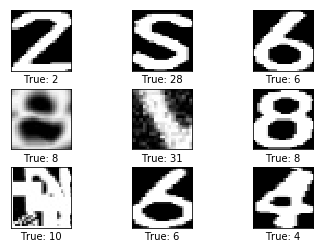

In [8]:
plot_images(data.x_train[:9], data.y_train_cls[:9])

In [9]:
# Convolutional Layer 1.
filter_size1 = 5
num_filters1 = 16

# Convolutional Layer 2.
filter_size2 = 5
num_filters2 = 36

# Fully-connected layer.
fc_size = 128

In [10]:
new_weights = lambda shape: tf.Variable(tf.truncated_normal(shape, stddev=0.05))
new_biases = lambda length: tf.Variable(tf.constant(0.05, shape=[length]))

In [11]:
def new_conv_layer(inp, num_input_channels, filter_size, num_filters, use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=inp, filter=weights,
                         strides=[1, 1, 1, 1], padding='SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1], padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [12]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [13]:
def new_fc_layer(inp, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(inp, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [14]:
x = tf.placeholder(tf.float32, shape=[None, data.img_size_flat], name='x')
x_image = tf.reshape(x, [-1, data.img_size, data.img_size, 1])
y_true = tf.placeholder(tf.float32, shape=[None, data.num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [15]:
layer_conv1, weights_conv1 = new_conv_layer(inp=x_image, num_input_channels=1,
                                            filter_size=filter_size1, num_filters=num_filters1,
                                            use_pooling=True)

layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [16]:
layer_conv2, weights_conv2 = new_conv_layer(inp=layer_conv1, num_input_channels=num_filters1,
                                            filter_size=filter_size2, num_filters=num_filters2,
                                            use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [17]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [18]:
num_features

1764

In [19]:
layer_fc1 = new_fc_layer(inp=layer_flat, num_inputs=num_features,
                         num_outputs=fc_size, use_relu=True)

layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [20]:
layer_fc2 = new_fc_layer(inp=layer_fc1, num_inputs=fc_size,
                         num_outputs=data.num_classes, use_relu=False)

layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 36) dtype=float32>

In [21]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                           labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

In [24]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [25]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [26]:
session = tf.Session()

In [27]:
session.run(tf.global_variables_initializer())

In [28]:
train_batch_size = 64

In [29]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [30]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [31]:
def plot_confusion_matrix(cls_pred):
    from sklearn.metrics import confusion_matrix
    cls_true = data.y_test_cls
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

In [34]:
test_batch_size = 256

def print_test_accuracy():
    cls_pred = np.zeros(shape=data.num_test, dtype=np.int)
    i = 0

    while i < data.num_test:
        j = min(i + test_batch_size, data.num_test)
        
        images = data.x_test_flat[i:j, :]
        labels = data.y_test[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.y_test_cls
    
    correct = cls_true.transpose() == cls_pred
    
    correct_sum = correct.sum()
    acc = float(correct_sum) / data.num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, data.num_test))

In [33]:
optimize(1000)

Optimization Iteration:      1, Training Accuracy:   6.2%
Optimization Iteration:    101, Training Accuracy:  76.6%
Optimization Iteration:    201, Training Accuracy:  89.1%
Optimization Iteration:    301, Training Accuracy:  98.4%
Optimization Iteration:    401, Training Accuracy: 100.0%
Optimization Iteration:    501, Training Accuracy: 100.0%
Optimization Iteration:    601, Training Accuracy: 100.0%
Optimization Iteration:    701, Training Accuracy: 100.0%
Optimization Iteration:    801, Training Accuracy: 100.0%
Optimization Iteration:    901, Training Accuracy: 100.0%
Time usage: 0:00:38


In [35]:
print_test_accuracy()

Accuracy on Test-Set: 50.2% (165 / 329)


In [58]:
images = data.x_val_flat
labels = data.y_val

feed_dict = {x: images, y_true: labels}

cls_pred = session.run(y_pred_cls, feed_dict=feed_dict)

cls_true = data.y_val_cls

correct = cls_true.transpose() == cls_pred
    
correct_sum = correct.sum()
acc = float(correct_sum) / data.num_test

# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, data.num_test))

Accuracy on Test-Set: 0.0% (12 / 27009)


In [ ]:
data.